In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from datetime import datetime

In [2]:
%%capture
!pip install wandb --upgrade

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
config = dict(
    epochs=80,
    classes=10, #fix later
    batch_size=128
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
def model_pipeline(hyperparameters):
  with wandb.init(project="pytorch prestarter with more logs", config=hyperparameters):
    config = wandb.config
    model, train_loader, test_data, test_loader, criterion, optimizer = make(config)
    print(model)

    train(model, train_loader, criterion, optimizer, config)
    test(model, test_loader)
    log_misc(model, test_data, test_loader)
  
  return model

In [6]:
def make(config):
  train, test = get_data()
  train_loader = make_loader(train, batch_size=config.batch_size, train=True)
  test_loader = make_loader(test, batch_size=config.batch_size, train=False)

  model = CNN(config.classes)
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  return model, train_loader, test, test_loader, criterion, optimizer

In [7]:
def get_data():
  transformer_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor()
  ])
  train_dataset = torchvision.datasets.CIFAR10(
    root=".",
    train=True,
    transform=transformer_train,
    download=True
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root=".",
      train=False,
      transform=transforms.ToTensor(),
      download=True
  )
  return train_dataset, test_dataset

def make_loader(dataset, batch_size, train=True):
  return torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      shuffle=train
  )

In [8]:
def train(model, loader, criterion, optimizer, config):
  wandb.watch(model, criterion, log="all", log_freq=10)

  epochs = config.epochs
  example_ct = 0
  batch_ct = 0

  for epoch in range(epochs):
    model.train()
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      example_ct += len(images)
      batch_ct += 1

      if (batch_ct + 1) % 250 == 0:
        wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
        print(
            f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}"
        )

In [9]:
def test(model, test_loader):
    model.eval()
    
    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [10]:
def log_misc(model, test_data, test_loader):
  # per class accuracy
  x_test = test_data.data
  y_test = np.array(test_data.targets)
  p_test = np.array([])

  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
  cm = confusion_matrix(y_test, p_test)
  plot_confusion_matrix(cm, list(range(10)))

  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

  wandb.define_metric("per class accuracy", summary="max")
  for i in range(10):
    log_dict = {
        "per class accuracy": cm_normalized[i, i]
    }
    wandb.log(log_dict)
  
  # misclassification

  labels = '''airplane
    automobile
    bird
    cat
    deer
    dog
    frog
    horse
    ship
    truck'''.split()
  
  # Show some misclassified examples
  p_test = p_test.astype(np.uint8)
  misclassified_idx = np.where(p_test != y_test)[0]
  sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
  plt.figure(figsize=(32,32))
  wandb.define_metric("misclassification examples")
  for j, i in enumerate(sample_idx):
    plt.subplot(10, 1, j + 1)
    plt.axis('off')
    plt.imshow(x_test[i].reshape(32,32,3))
    summ = ("True: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))
    plt.title(summ)
    image = wandb.Image(x_test[i].reshape(32,32,3), caption=summ)
    wandb.log({"misclassification examples" : image})

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [12]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

wandb: Currently logged in as: kyuds (use `wandb login --relogin` to force relogin)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

/usr/local/lib/python3.7/dist-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/usr/local/lib/python3.7/dist-packages/wandb/wandb_torch.py:287: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tensor.shape == torch.Size([0]) or (~torch.isfinite(tensor)).all().item()
/usr/local/lib/python3.7/dist-packages/wandb/wandb_torch.py:290: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record 

Confusion matrix, without normalization
[[867  12  41  17   8   1   5   6  29  14]
 [  2 962   0   4   1   0   1   2   3  25]
 [ 16   1 867  37  25  20  24   5   3   2]
 [ 11   0  32 846  20  56  18  11   5   1]
 [  5   2  39  37 862  13  17  24   0   1]
 [  1   0  31 152  15 781   4  13   1   2]
 [  2   1  30  58   8   7 891   1   2   0]
 [  8   0  12  31  23  29   1 889   2   5]
 [ 27  18   8   7   0   0   3   0 926  11]
 [  9  68   1   7   0   1   0   0   7 907]]


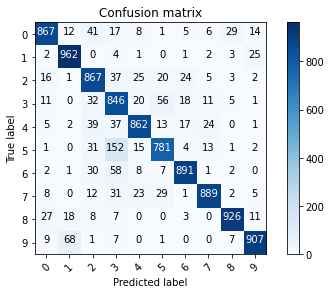

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▅▄▄▃▃▄▃▃▃▃▄▃▃▄▃▂▂▂▃▂▂▂▂▃▃▂▁▁▂▁▃▂▂▂▂▁▂
per class accuracy,▄█▄▄▄▁▅▅▇▆
test_accuracy,▁
epoch,79
loss,0.28681
test_accuracy,0.8799


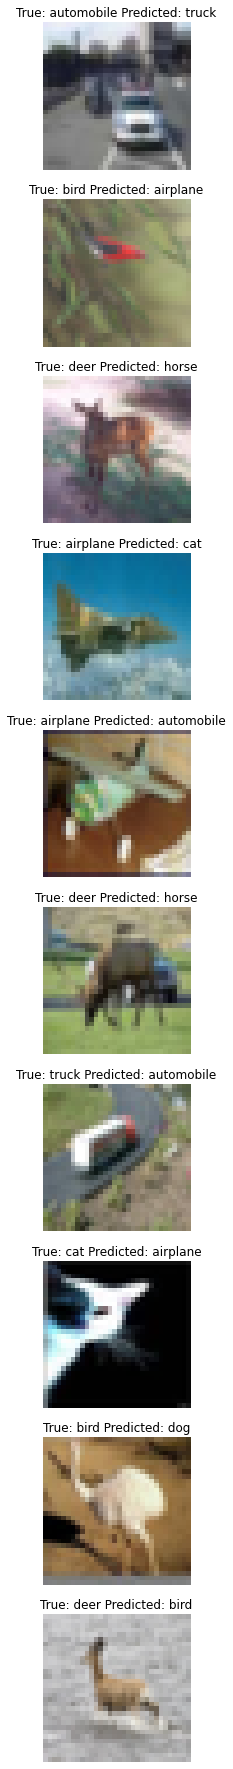

In [13]:
model = model_pipeline(config)